<a href="https://colab.research.google.com/github/Yoshani/Pump-It-Up/blob/master/Pump_It_Up_Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install category_encoders

In [42]:
import numpy as np
import pandas as pd
import pandas_profiling
from sklearn import preprocessing
import datetime as dt
from numpy import mean
from numpy import std
from sklearn.decomposition import PCA

# plotting
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

# feature selection
from sklearn.feature_selection import mutual_info_classif
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

# encoders
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

# training
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

# classifiers
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier, VotingClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [3]:
def impute_median(series):
    return series.fillna(series.median())

def impute_mean(series):
    return series.fillna(series.mean())

def make_mi_scores(X, y):
    X_mi = X.copy()
    y_mi = y.copy()
    for colname in X_mi.select_dtypes(["object", "category"]):
        X_mi[colname], _ = X_mi[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X_mi.dtypes]
    mi_scores = mutual_info_classif(X_mi, y_mi.values.ravel(), discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_mi.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    return

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

# Get datasets

In [4]:
features_df = pd.read_csv(
    "/content/drive/MyDrive/PumpItUp/TrainingSet.csv", 
    index_col="id",
    low_memory=False
)
labels_df = pd.read_csv(
    "/content/drive/MyDrive/PumpItUp/TrainingLabels.csv", 
    index_col="id"
)
test_df = pd.read_csv(
    "/content/drive/MyDrive/PumpItUp/TestSet.csv", 
    index_col="id",
    low_memory=False
)

In [5]:
features_df.tail()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
26348,0.0,2011-03-23,World Bank,191,World,38.104048,-6.747464,Kwa Mzee Lugawa,0,Wami / Ruvu,Kikatanyemba,Morogoro,5,2,Morogoro Rural,Ngerengere,150,True,GeoData Consultants Ltd,VWC,NaN,True,2002,nira/tanira,nira/tanira,handpump,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump


In [6]:
X = features_df.copy()
y = labels_df.copy()
X_test = test_df.copy()

# **Preprocessing**

Apply feature selection

In [7]:
# Combine train data with test data
df=X.append(X_test)

In [8]:
# Combined training dataset with labels
combined = X.copy()
combined['status_group'] = y['status_group']

In [9]:
df.dtypes

amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_qual

In [10]:
# Recorded_by column contains a constant value --> Drop it
df.drop(['recorded_by'], axis=1, inplace=True)

In [11]:
# Remove columns with high zero count
df.drop(columns=['amount_tsh', 'num_private', 'scheme_name'], axis=1, inplace=True)

In [12]:
# Some columns have another column expressing the same thing --> Drop them
df.drop(columns=['extraction_type','extraction_type_group', 'payment_type', 'quantity_group', 'source_type', 'waterpoint_type_group', 'region'], axis=1, inplace=True)

In [13]:
# Drop some high cardinality columns
df.drop(columns=['wpt_name', 'subvillage', 'ward'], axis=1, inplace=True)

# Handling missing values

amount_tsh,
gps_height,
longitude,
population,
num_private,
construction_year columns have zeros

We already dropped amount_tsh, num_private

Convert missing values with 0 to NaN

In [14]:
# Construction year
df.loc[df['construction_year'] == 0,'construction_year'] = np.nan

In [15]:
# Number of missing values in each column
missing_val_count_by_column = (df.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

funder                4504
installer             4532
public_meeting        4155
scheme_management     4846
permit                3793
construction_year    25969
dtype: int64


1. Funder

In [16]:
# Fill missing funder values with 'Unknown'
df['funder'] = df['funder'].fillna("Unknown")

2. Installer

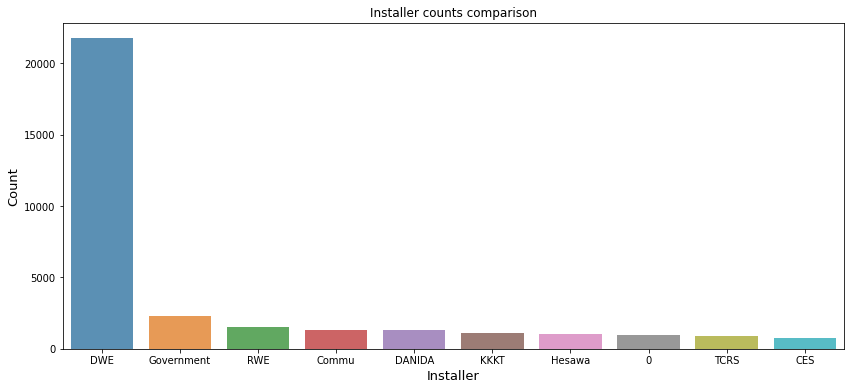

In [ ]:
item_counts = df['installer'].value_counts()
item_counts = item_counts[:10,]
plt.figure(figsize=(14,6))
sns.barplot(x=item_counts.index, y=item_counts.values, alpha=0.8)
plt.title('Installer counts comparison')
plt.ylabel('Count', fontsize=13)
plt.xlabel('Installer', fontsize=13)
plt.show()

DWE is significantly frequent. Therefore let's fill the missing values with this value

In [17]:
# Replace NaN with most frequent value
most_frequent_category=X['installer'].mode()[0]  # 'DWE' is the most frequent value
print(most_frequent_category)

df['installer'] = df['installer'].fillna(most_frequent_category)

DWE


3. Population

Population values are related to region

In [18]:
# Fill missing values with median grouped by region code
df['population'] = df['population'].fillna(df.groupby('region_code')['population'].transform('median'))

4. Public meeting

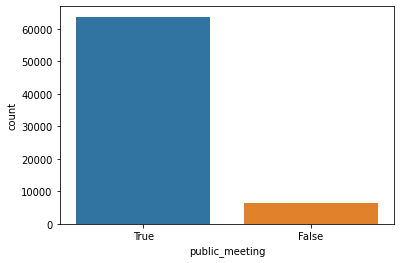

In [ ]:
sns.countplot(x="public_meeting", data=df)

Majority are public meeetings

In [19]:
# Fill missing values with true
df['public_meeting'] = df['public_meeting'].fillna(True)

6. Scheme Management

In [ ]:
df['scheme_management'].unique()

array(['VWC', 'Other', nan, 'Private operator', 'WUG', 'Water Board',
       'WUA', 'Water authority', 'Company', 'Parastatal', 'Trust', 'SWC',
       'None'], dtype=object)

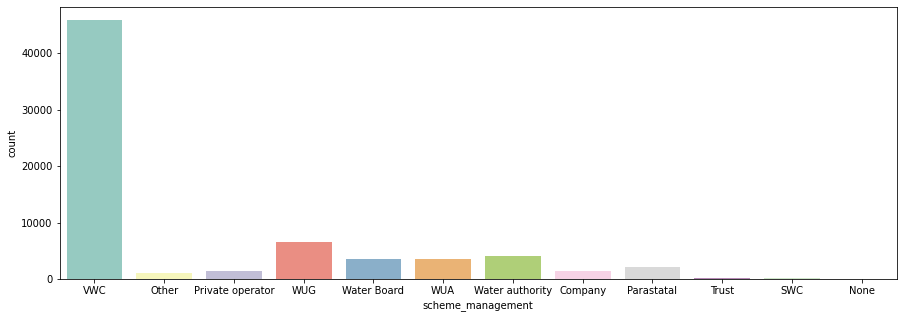

In [ ]:
plt.subplots(figsize=(15, 5))
sns.countplot(x='scheme_management', data=df, palette="Set3")

VWC has a significant frequency

In [20]:
# Fill missing scheme management values with mode
most_frequent_category=X['scheme_management'].mode()[0]  # 'VWC' is the most frequent value
print(most_frequent_category)

df['scheme_management'] = df['scheme_management'].fillna(most_frequent_category)

VWC


7. Permit

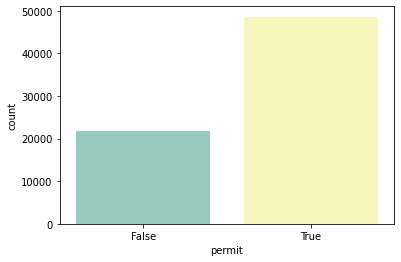

In [ ]:
sns.countplot(x='permit', data=df, palette="Set3")

In [ ]:
df['permit'].value_counts()

True     48606
False    21851
Name: permit, dtype: int64

In [21]:
# Fill missing permit values with 'Unknown'
df['permit'] = df['permit'].fillna("Unknown")

8. Construction year

In [ ]:
df['construction_year'].mean()

1996.8709430210642

In [ ]:
df['construction_year'].value_counts()

Majority of construction year values are missing

In [22]:
# Fill construction year with dummy value
df['construction_year'] = df['construction_year'].fillna(1950)

9. Longitude/latitude

In [23]:
df.loc[df['longitude'] == 0, ['longitude', 'latitude']] = np.nan
df["longitude"] = df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).longitude
df["latitude"] = df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).latitude

df.loc[df['gps_height'] == 0, 'gps_height'] = np.nan
df["gps_height"] = df.groupby("region_code").transform(lambda x: x.fillna(x.mean())).gps_height

df=df.fillna(df.mean())

# Feature Engineering

1. New features with mathematical transforms

Calculate operation time using date recorded and construction year

In [24]:
df['operation_time']=df.date_recorded.apply(pd.to_datetime)-df.construction_year.apply(lambda x: pd.to_datetime(x,format='%Y'))
df['operation_time']=df.operation_time.apply(lambda x: float(x.days)/ (365.25*24*60*60*1e9))
df.loc[df['operation_time'] < 0,df.columns=='operation_time'] = 63.92060232717317

Take log population to normalize the population

In [25]:
df['logPopulation'] = df.population.apply(np.log1p)

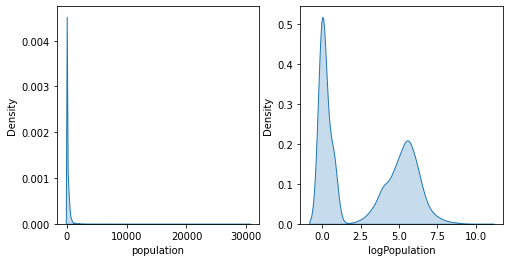

In [ ]:
# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(df.population, shade=True, ax=axs[0])
sns.kdeplot(df.logPopulation, shade=True, ax=axs[1]);

In [26]:
df.drop(['population'], axis=1, inplace=True)

2. Feature splitting

Extract year, month, day separately from date recorded

In [27]:
df['year']=pd.to_datetime(df.date_recorded).dt.year
df['month']=pd.to_datetime(df.date_recorded).dt.month
df['day']=pd.to_datetime(df.date_recorded).dt.day

In [28]:
# Drop date recorded
df.drop(['date_recorded'], axis=1, inplace=True)

3. Principal Component Analysis

In [29]:
df.head()

,funder,gps_height,installer,longitude,latitude,basin,region_code,district_code,lga,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_class,waterpoint_type,operation_time,logPopulation,year,month,day
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,Roman,1390.0,Roman,34.938093,-9.856322,Lake Nyasa,11,5,Ludewa,True,VWC,False,1999.0,gravity,vwc,user-group,pay annually,soft,good,enough,spring,groundwater,communal standpipe,1.411704e-13,4.700480,2011,3,14
8776,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Lake Victoria,20,2,Serengeti,True,Other,True,2010.0,gravity,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,surface,communal standpipe,3.675818e-14,5.638355,2013,3,6
34310,Lottery Club,686.0,World vision,37.460664,-3.821329,Pangani,21,4,Simanjiro,True,VWC,True,2009.0,gravity,vwc,user-group,pay per bucket,soft,good,enough,dam,surface,communal standpipe multiple,4.803914e-14,5.525453,2013,2,25
67743,Unicef,263.0,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,90,63,Nanyumbu,True,VWC,True,1986.0,submersible,vwc,user-group,never pay,soft,good,dry,machine dbh,groundwater,communal standpipe multiple,3.133635e-13,4.077537,2013,1,28
19728,Action In A,26.0,Artisan,31.130847,-1.825359,Lake Victoria,18,1,Karagwe,True,VWC,True,1950.0,gravity,other,other,never pay,soft,good,seasonal,rainwater harvesting,surface,communal standpipe,7.121264e-13,0.000000,2011,7,13


In [29]:
pca_df = df[:len(features_df)]
X_pca = pca_df.loc[:, ['longitude', 'latitude']]
pca, X_pca, loadings = apply_pca(X_pca)
loadings

,PC1,PC2
longitude,0.707107,-0.707107
latitude,-0.707107,-0.707107


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f868e386f90>,
      dtype=object)

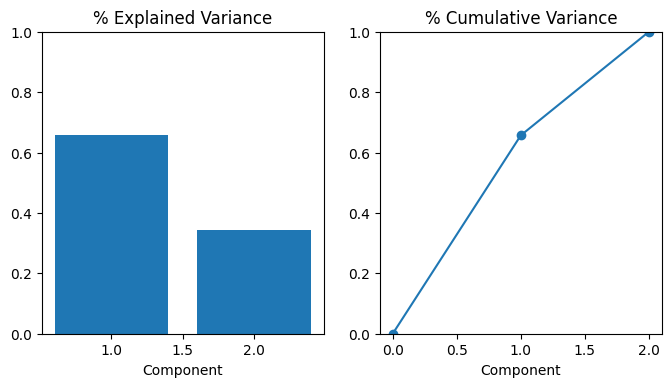

In [31]:
plot_variance(pca)

In [32]:
mi_scores = make_mi_scores(X_pca, y)
mi_scores

PC1    0.079115
PC2    0.052694
Name: MI Scores, dtype: float64

PCA components for longitude and latitude are not very significant

# Encoding

1. Binary encoding

Suitable for high cardinality attributes. funder, installer and lga have high cardinality

In [30]:
enc = ce.BinaryEncoder(cols=['funder', 'installer', 'lga']).fit(df)
df = enc.transform(df)
df.head()

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,funder_0,funder_1,funder_2,funder_3,funder_4,funder_5,funder_6,funder_7,funder_8,funder_9,funder_10,funder_11,funder_12,gps_height,installer_0,installer_1,installer_2,installer_3,installer_4,installer_5,installer_6,installer_7,installer_8,installer_9,installer_10,installer_11,installer_12,longitude,latitude,basin,region_code,district_code,lga_0,lga_1,lga_2,lga_3,lga_4,lga_5,lga_6,lga_7,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_class,waterpoint_type,operation_time,logPopulation,year,month,day
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,0,0,0,0,0,0,0,0,0,0,0,0,1,1390.0,0,0,0,0,0,0,0,0,0,0,0,0,1,34.938093,-9.856322,Lake Nyasa,11,5,0,0,0,0,0,0,0,1,True,VWC,False,1999.0,gravity,vwc,user-group,pay annually,soft,good,enough,spring,groundwater,communal standpipe,1.411704e-13,4.700480,2011,3,14
8776,0,0,0,0,0,0,0,0,0,0,0,1,0,1399.0,0,0,0,0,0,0,0,0,0,0,0,1,0,34.698766,-2.147466,Lake Victoria,20,2,0,0,0,0,0,0,1,0,True,Other,True,2010.0,gravity,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,surface,communal standpipe,3.675818e-14,5.638355,2013,3,6
34310,0,0,0,0,0,0,0,0,0,0,0,1,1,686.0,0,0,0,0,0,0,0,0,0,0,0,1,1,37.460664,-3.821329,Pangani,21,4,0,0,0,0,0,0,1,1,True,VWC,True,2009.0,gravity,vwc,user-group,pay per bucket,soft,good,enough,dam,surface,communal standpipe multiple,4.803914e-14,5.525453,2013,2,25
67743,0,0,0,0,0,0,0,0,0,0,1,0,0,263.0,0,0,0,0,0,0,0,0,0,0,1,0,0,38.486161,-11.155298,Ruvuma / Southern Coast,90,63,0,0,0,0,0,1,0,0,True,VWC,True,1986.0,submersible,vwc,user-group,never pay,soft,good,dry,machine dbh,groundwater,communal standpipe multiple,3.133635e-13,4.077537,2013,1,28
19728,0,0,0,0,0,0,0,0,0,0,1,0,1,26.0,0,0,0,0,0,0,0,0,0,0,1,0,1,31.130847,-1.825359,Lake Victoria,18,1,0,0,0,0,0,1,0,1,True,VWC,True,1950.0,gravity,other,other,never pay,soft,good,seasonal,rainwater harvesting,surface,communal standpipe,7.121264e-13,0.000000,2011,7,13


In [31]:
# binary encoding introduced some all zero columns
df.drop(['funder_0', 'lga_0', 'installer_0'], axis=1, inplace=True)

2. Ordinal encoding

In [32]:
permit_map = {
    "Unknown": 0,
    False: 1,
    True: 2
  }

df['permit'] = df['permit'].map(permit_map)

3. Label encoding

In [33]:
df['public_meeting'] = df['public_meeting'].astype(int)

In [34]:
df.select_dtypes(["object", "category"]).nunique()

basin                     9
scheme_management        12
extraction_type_class     7
management               12
management_group          5
payment                   7
water_quality             8
quality_group             6
quantity                  5
source                   10
source_class              3
waterpoint_type           7
dtype: int64

Label encode columns having >10 cardinality

In [35]:
le_df = df.select_dtypes(["object", "category"])
le_cols = le_df.loc[:, [col for col in le_df.columns if (le_df[col].nunique() > 10)]].columns.tolist()

for col in le_cols:
  df[col] = LabelEncoder().fit_transform(df[col])

4. One-Hot encoding

In [36]:
one_hot_cols = df.select_dtypes(["object", "category"]).columns.tolist()

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[one_hot_cols]))
OH_cols.index = df.index

# give intuitive column names
OH_cols.columns = OH_encoder.get_feature_names(one_hot_cols)

num_df = df.drop(one_hot_cols, axis=1)
df = pd.concat([num_df, OH_cols], axis=1)

In [37]:
df.head()

,funder_1,funder_2,funder_3,funder_4,funder_5,funder_6,funder_7,funder_8,funder_9,funder_10,funder_11,funder_12,gps_height,installer_1,installer_2,installer_3,installer_4,installer_5,installer_6,installer_7,installer_8,installer_9,installer_10,installer_11,installer_12,longitude,latitude,region_code,district_code,lga_1,lga_2,lga_3,lga_4,lga_5,lga_6,lga_7,public_meeting,scheme_management,permit,construction_year,...,payment_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,0,0,0,0,0,0,0,0,0,0,0,1,1390.0,0,0,0,0,0,0,0,0,0,0,0,1,34.938093,-9.856322,11,5,0,0,0,0,0,0,1,1,7,1,1999.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8776,0,0,0,0,0,0,0,0,0,0,1,0,1399.0,0,0,0,0,0,0,0,0,0,0,1,0,34.698766,-2.147466,20,2,0,0,0,0,0,1,0,1,2,2,2010.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
34310,0,0,0,0,0,0,0,0,0,0,1,1,686.0,0,0,0,0,0,0,0,0,0,0,1,1,37.460664,-3.821329,21,4,0,0,0,0,0,1,1,1,7,2,2009.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
67743,0,0,0,0,0,0,0,0,0,1,0,0,263.0,0,0,0,0,0,0,0,0,0,1,0,0,38.486161,-11.155298,90,63,0,0,0,0,1,0,0,1,7,2,1986.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19728,0,0,0,0,0,0,0,0,0,1,0,1,26.0,0,0,0,0,0,0,0,0,0,1,0,1,31.130847,-1.825359,18,1,0,0,0,0,1,0,1,1,7,2,1950.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Normalization

Min max normalization

In [38]:
df=(df - df.min())/(df.max() - df.min())

Standard normalization

In [ ]:
df = (df - mean(df)) / std(df)

# Separate training and test set

In [39]:
X = df[:len(features_df)]
X_test = df[len(features_df):]

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y.status_group, test_size=0.1, random_state=10)

In [44]:
X_train.head()

,funder_1,funder_2,funder_3,funder_4,funder_5,funder_6,funder_7,funder_8,funder_9,funder_10,funder_11,funder_12,gps_height,installer_1,installer_2,installer_3,installer_4,installer_5,installer_6,installer_7,installer_8,installer_9,installer_10,installer_11,installer_12,longitude,latitude,region_code,district_code,lga_1,lga_2,lga_3,lga_4,lga_5,lga_6,lga_7,public_meeting,scheme_management,permit,construction_year,...,payment_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
32154,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.082665,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.762862,0.401036,0.040816,0.0250,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.636364,1.0,0.571429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6131,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.375455,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.628975,0.518671,0.000000,0.0375,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.636364,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
34216,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.661318,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.556348,0.740983,0.204082,0.0375,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.818182,1.0,0.968254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2744,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.474015,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.771010,0.681492,0.020408,0.0375,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,0.968254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
36293,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.449720,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.354400,0.813389,0.183673,0.0500,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.636364,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


PCA heatmap

In [47]:
pca = PCA(n_components = 2)
pca.fit(X_train)
x_pca = pca.transform(X_train)
  
x_pca.shape

(53460, 2)

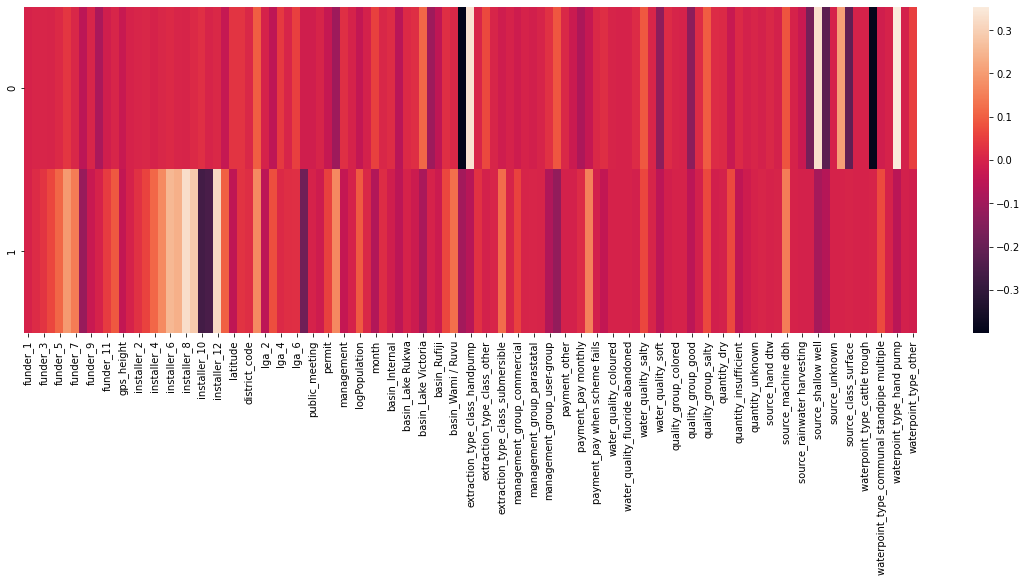

In [49]:
df_comp = pd.DataFrame(pca.components_, columns = X_train.columns)
  
plt.figure(figsize =(20, 6))
  
# plotting heatmap
sns.heatmap(df_comp)

# Hyperparameter Tuning

In [40]:
def grid_search(model, params, X_tune, y_tune):
  clf =  GridSearchCV(model, params, cv=5, scoring='accuracy')
  clf.fit(X_tune, y_tune)
  return clf.best_score_, clf.best_params_

In [45]:
X_tune=X
y_tune = y.status_group

In [46]:
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [100, 500, 1000, 1100],
            'max_depth': [6, 10, 12, 14, 20, 22]
        }
    },
    'xgboost' : {
        'model': XGBClassifier(),
        'params': {
            'max_depth': [10, 12, 14, 20],
            'eta': [0.1, 0.2, 0.3, 0.4]
        }
    }
}


Grid Search

In [47]:
best_score, best_params = grid_search(model_params['random_forest']['model'], model_params['random_forest']['params'], X_tune, y_tune)
print(best_score, best_params)

0.8133670033670034 {'max_depth': 20, 'n_estimators': 1000}


In [40]:
best_score, best_params = grid_search(model_params['xgboost']['model'], model_params['xgboost']['params'], X_tune, y_tune)
print(best_score, best_params)

0.8123400673400674 {'eta': 0.1, 'max_depth': 14}


# **Model training**

Define models

In [56]:
modelRFC = RandomForestClassifier(n_estimators=1300, min_samples_split=10, criterion='gini')

modelETC = ExtraTreesClassifier(n_estimators=1000, min_samples_split=10)

modelXGB = XGBClassifier(objective = 'multi:softmax', 
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = 0.1,
                      max_depth = 14, colsample_bytree = 0.4, num_boost_round=1000, nfold=4, early_stopping_rounds=10)

modelGB = GradientBoostingClassifier(random_state=8, n_estimators=1000)

modelLGB = lgb.LGBMClassifier(learning_rate=0.03, n_estimators=478, max_depth=5, min_samples_split=100, min_samples_leaf=100, random_state=27, gamma=0.1,
                                                       subsample=0.8, reg_alpha = 0.001, reg_lambda=10, objective = 'multi:softmax', boosting_type='goss')

modelSVM = SVC(gamma='auto', kernel='rbf')

modelCAT = CatBoostClassifier(silent=True, max_ctr_complexity=5, task_type='CPU', iterations=10000,
        eval_metric='AUC', od_type='Iter', od_wait=500, loss_function = 'MultiClass', random_seed=42)

# neural network
modelMLP = MLPClassifier(hidden_layer_sizes=(200,100,), learning_rate='invscaling', learning_rate_init=0.01,
                          power_t=0.5, max_iter=1000, shuffle=True, tol=1e-4, activation='logistic', 
                          early_stopping=True, validation_fraction=0.1, n_iter_no_change=12, max_fun=15000,
                         random_state=8, solver='adam',batch_size=1024)

Single scores

In [44]:
modelRFC.fit(X_train, y_train)
scoreRFC= modelRFC.score(X_valid,y_valid)
scoreRFC

0.8164983164983165

In [45]:
modelETC.fit(X_train, y_train)
scoreETC= modelETC.score(X_valid,y_valid)
scoreETC

0.8141414141414142

In [46]:
modelXGB.fit(X_train, y_train)
scoreXGB= modelXGB.score(X_valid,y_valid)
scoreXGB

0.8191919191919191

In [47]:
modelSVM.fit(X_train, y_train)
scoreSVM= modelSVM.score(X_valid,y_valid)
scoreSVM

0.7449494949494949

In [48]:
modelMLP.fit(X_train, y_train)
scoreMLP = modelMLP.score(X_valid,y_valid)
scoreMLP

0.7850168350168351

In [49]:
modelCAT.fit(X_train, y_train)
scoreCAT = modelCAT.score(X_valid,y_valid)
scoreCAT

0.8092592592592592

In [51]:
modelLGB.fit(X_train, y_train)
scoreLGB = modelLGB.score(X_valid,y_valid)
scoreLGB

0.7863636363636364

In [52]:
modelGB.fit(X_train, y_train)
scoreGB = modelGB.score(X_valid,y_valid)
scoreGB

0.7764309764309765

Ensembling

In [57]:
estimators_stacked = [
              ('xgb', modelXGB),
              ('rn', modelRFC),
              # ('xt', modelETC),
              # ('mlp', modelMLP),
              # ('lgb', modelLGB),
              #('svc', modelSVM),
              #('cat', modelCAT),
              #('gb', modelGB),
             ]

# Stacking Classifier
stacked_estimator =  StackingClassifier(estimators=estimators_stacked,
                                    final_estimator=LogisticRegression()  
                                  )
# Voting Classifier
voting_estimator = VotingClassifier(estimators=estimators_stacked, 
                        voting='hard')

In [58]:
stacked_estimator.fit(X_train, y_train)
scoreStack = stacked_estimator.score(X_valid,y_valid)
scoreStack

0.8202020202020202

In [55]:
voting_estimator.fit(X_train, y_train)
scoreVoting = voting_estimator.score(X_valid,y_valid)
scoreVoting

0.8191919191919191

# Train on entire dataset

In [ ]:
model=stacked_estimator
X_train=X
y_train = y.status_group

model.fit(X_train, y_train)

# Predict

In [ ]:
predict=model.predict(X_test)

# Submission

In [ ]:
submission_df = pd.read_csv("/content/drive/MyDrive/PumpItUp/SubmissionFormat.csv", 
                            index_col="id")

In [ ]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["status_group"] = predict

In [ ]:
submission_df['status_group'].unique()

In [ ]:
submission_df.to_csv('my_submission.csv', index=True)

In [ ]:
from google.colab import files
files.download('my_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>